BloomTech Data Science

*Unit 2, Sprint 2, Module 2*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

    #Connect to remote data
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd /content/drive/My Drive/Kaggle

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [ ]:
# Import Block
import pandas as pd
import numpy as np
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')
        
    # Build new Pump Age feature
    df['pump_age'] = pd.to_datetime(df['date_recorded']).dt.year - pd.to_datetime(df['construction_year']).dt.year
    df.drop(columns=['date_recorded'], inplace=True)

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop duplicate columns
    #automatic method is too unreliable
    #dupe_cols = [col for col in df.head(50).T.duplicated().index
    #             if df.head(50).T.duplicated()[col]]
    dupe_cols = ['subvillage', 'region', 'extraction_type_group', 'payment', 
                 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group']
    df.drop(columns=dupe_cols, inplace=True)    

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle("train_features.csv", "train_labels.csv")
X_test = wrangle("test_features.csv")

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [ ]:
X = df.drop(columns=['status_group'])
y = df['status_group']

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
model_dum = DummyClassifier(strategy='prior').fit(X_train, y_train)
baseline_acc = accuracy_score(y_train, model_dum.predict(X_train))
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [ ]:
model_rf = make_pipeline(OrdinalEncoder(), SimpleImputer(), RandomForestClassifier(random_state=42, n_jobs=-1)).fit(X_train, y_train)

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [ ]:
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9953965539918453
Validation Accuracy Score: 0.7967171717171717


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [ ]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
print("Default Model Parameters:")
print("Tree Count: ", len(model_rf.named_steps['randomforestclassifier'].estimators_))
print("Avg. Tree Depth: ", np.mean([estimator.get_depth() for estimator in model_rf.named_steps['randomforestclassifier'].estimators_]))
print("Avg. Tree Nodes: ", np.mean([estimator.tree_.node_count for estimator in model_rf.named_steps['randomforestclassifier'].estimators_]))
print(".........................")

# new model + tests below
model_rfv2 = make_pipeline(OrdinalEncoder(drop_invariant=True), SimpleImputer(strategy='mean'), 
                           RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_samples=0.5,
                                                  max_depth=35, max_leaf_nodes=3100, max_features=0.4)).fit(X_train, y_train)

training_acc2 = accuracy_score(y_train, model_rfv2.predict(X_train))
val_acc2 = accuracy_score(y_val, model_rfv2.predict(X_val))

print('New Training Accuracy Score:', training_acc2)
print('New Validation Accuracy Score:', val_acc2)
print("Tuned Model Parameters:")
print("Tree Count: ", len(model_rfv2.named_steps['randomforestclassifier'].estimators_))
print("Avg. Tree Depth: ", np.mean([estimator.get_depth() for estimator in model_rfv2.named_steps['randomforestclassifier'].estimators_]))
print("Avg. Tree Nodes: ", np.mean([estimator.tree_.node_count for estimator in model_rfv2.named_steps['randomforestclassifier'].estimators_]))


Default Model Parameters:
Tree Count:  100
Avg. Tree Depth:  39.51
Avg. Tree Nodes:  14942.22
.........................
New Training Accuracy Score: 0.929790872024201
New Validation Accuracy Score: 0.8036616161616161
Tuned Model Parameters:
Tree Count:  100
Avg. Tree Depth:  33.84
Avg. Tree Nodes:  6199.0


# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

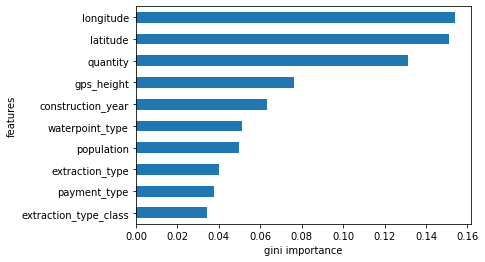

In [ ]:
y_pred = model_rf.predict(X_test)
assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

gini_imp = model_rf.named_steps['randomforestclassifier'].feature_importances_
feats = model_rf.named_steps['ordinalencoder'].get_feature_names()
pd.Series(data=gini_imp, index=feats).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [ ]:
# Generate test results with the revised model above

submission = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)
submission.columns = ['status_group']

# generate CSV
submission.to_csv('submission_jd_2.csv', )
# download
from google.colab import files
files.download("submission_jd_2.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>